# **Description** 
---
In this notebook I'm making a car classifier using the Stanford car dataset, which contains 196 classes. I'll be using a light pre-trained MobileNetV2 with transfer learning to train the model. All layers will be fine tuned and the last fully connected layer will be replaced entirely.

Dataset (196 classes):

Train folder: 8144 images, avg: 41.5 images per class.

Test folder: 8041 images, avg: 41.0 images per class.


In [2]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


#**Authorization**

---



In [3]:
!ls -lha kaggle.json

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!pip install -q kaggle

You should consider upgrading via the 'c:\users\hp\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [5]:
!mkdir -p ~/.kaggle

The syntax of the command is incorrect.


In [6]:
!cp kaggle.json ~/.kaggle/

'cp' is not recognized as an internal or external command,
operable program or batch file.


#**Data preparation**

---



In [7]:
# Download Stanford Cars dataset from kaggle

!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

Traceback (most recent call last):
  File "C:\Users\Hp\AppData\Local\Programs\Python\Python39\Scripts\kaggle-script.py", line 33, in <module>
    sys.exit(load_entry_point('kaggle==1.5.12', 'console_scripts', 'kaggle')())
  File "C:\Users\Hp\AppData\Local\Programs\Python\Python39\Scripts\kaggle-script.py", line 25, in importlib_load_entry_point
    return next(matches).load()
  File "c:\users\hp\appdata\local\programs\python\python39\lib\importlib\metadata.py", line 77, in load
    module = import_module(match.group('module'))
  File "c:\users\hp\appdata\local\programs\python\python39\lib\importlib\__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1030, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 972, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_remove

In [8]:
# Unzip dataset

!unzip /content/stanford-car-dataset-by-classes-folder.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
# Let's load dependencies

import os 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch.nn as nn
import torch, torchvision
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm, trange
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from utils.subprocess import incorrect_samples, class_score
from utils.visualization import plot_loss, imshow

##Defining subsets

In [11]:
# We will use train folder data for training and test folder data for validation

TRAIN_PATH = "/content/car_data/car_data/train/"
TEST_PATH = "/content/car_data/car_data/test/"

In [13]:
# All images will be scaled to a size of 300x300 px
RESCALE_SIZE = 300
DEVICE = torch.device("cuda") # We will use GPU
NCATS = len(os.listdir(TRAIN_PATH))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/car_data/car_data/train/'

In [14]:
def seed_worker(worker_id):
    np.random.seed(42)
    random.seed(42)

In [15]:
# Let`s define the train and val subsets and simple transforms

train_transforms = transforms.Compose([transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                                 transforms.RandomHorizontalFlip(),                   
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


test_transforms = transforms.Compose([transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = test_transforms)


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/car_data/car_data/train/'

In [16]:
trainloader = DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers = 2, worker_init_fn=seed_worker)
testloader = DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers = 2, worker_init_fn=seed_worker)

##Data vizualization

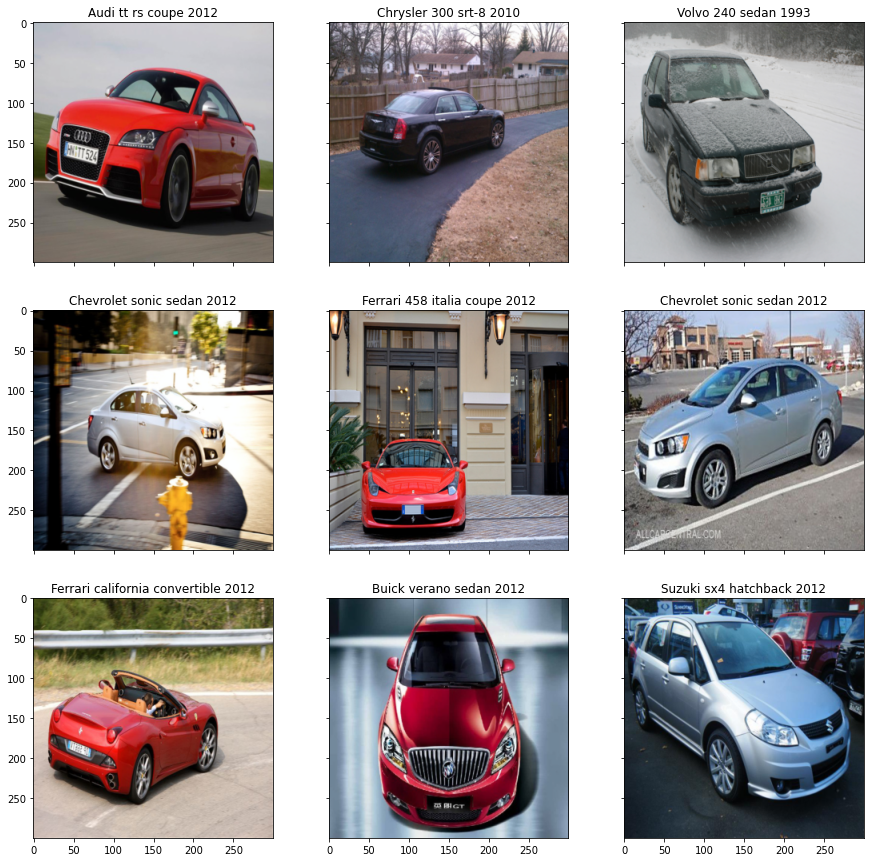

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15, 15), \
                        sharey=True, sharex=True)

train_size = len(train_dataset)

label_encoder = LabelEncoder().fit(train_dataset.classes)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, train_size))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), str(label_encoder.inverse_transform([label])[0]).split('_')))
    imshow(im_train.data.cpu(), plt_ax=fig_x, title=img_label)


#**Training**

---



In [18]:
# Training loop
# We will use accuracy as a metric

def train(train_loader, val_loader, model, num_epochs, optimizer, criterion, scheduler=None):

    best_model_wts = model.state_dict()
    best_epoch = 0
    best_score = 0
    
    
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    loaders = {"train": train_loader, "val": val_loader}

    for epoch in pbar:

        for k, dataloader in loaders.items():

            running_loss = 0.0
            epoch_preds, epoch_batches = [], []

            for batch in tqdm(dataloader, leave=False, desc=f"{k} iter:"):
                x_batch, y_batch = batch
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                if k == "train":
                    model.train()  
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()  
                    optimizer.step()  
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                        loss = criterion(outp, y_batch)

                preds = outp.argmax(-1)

                epoch_preds += preds.cpu()
                epoch_batches += y_batch.cpu()
                running_loss += loss.item() * x_batch.size(0)

            epoch_score = accuracy_score(epoch_preds, epoch_batches)
            epoch_loss = running_loss / len(dataloader.dataset)
            losses[k].append(epoch_loss)

  
            
            if k == 'val': 
              print(f'Epoch: {epoch + 1} of {num_epochs}  Score: {epoch_score}')
              if scheduler is not None:
                scheduler.step(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Score: {:.4f}'.format(k, epoch_loss, epoch_score))

            if k == 'val' and epoch_score > best_score:
               best_score = epoch_score
               best_epoch = epoch + 1
               best_model_wts = model.state_dict()
      
                
            
    print(f'Best score: {best_score}\nEpoch {best_epoch} of {num_epochs}')
    model.load_state_dict(best_model_wts)
    return model, losses, best_score

In [19]:
torch.cuda.empty_cache()

In [20]:
# Let's choose pretrained MobileNetV2 as the model.

mob_netv2 = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [21]:
# MobileNetV2 fine-tuning (changing output size) 

mob_netv2.classifier[1] = nn.Linear(in_features=mob_netv2.classifier[1].in_features, out_features=NCATS)

In [22]:
print(mob_netv2)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [23]:
mob_netv2 = mob_netv2.to(DEVICE)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mob_netv2.parameters(), lr=1e-4, weight_decay = 1e-5) # Adam with L2-regularization 

mob_netv2, losses_mob_netv2, accuracy_mob_netv2 = train(trainloader,testloader, model=mob_netv2, num_epochs=10, optimizer=optimizer, criterion=criterion) # Training loop with 10 epochs


Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/255 [00:00<?, ?it/s]

val iter::   0%|          | 0/252 [00:00<?, ?it/s]

Epoch: 1 of 10  Score: 0.23181196368610868


train iter::   0%|          | 0/255 [00:00<?, ?it/s]

val iter::   0%|          | 0/252 [00:00<?, ?it/s]

Epoch: 2 of 10  Score: 0.4934709613232185


train iter::   0%|          | 0/255 [00:00<?, ?it/s]

val iter::   0%|          | 0/252 [00:00<?, ?it/s]

Epoch: 3 of 10  Score: 0.6591219997512747


train iter::   0%|          | 0/255 [00:00<?, ?it/s]

val iter::   0%|          | 0/252 [00:00<?, ?it/s]

Epoch: 4 of 10  Score: 0.7315010570824524


train iter::   0%|          | 0/255 [00:00<?, ?it/s]

val iter::   0%|          | 0/252 [00:00<?, ?it/s]

Epoch: 5 of 10  Score: 0.7982837955478175


train iter::   0%|          | 0/255 [00:00<?, ?it/s]

val iter::   0%|          | 0/252 [00:00<?, ?it/s]

Epoch: 6 of 10  Score: 0.8202959830866807


train iter::   0%|          | 0/255 [00:00<?, ?it/s]

val iter::   0%|          | 0/252 [00:00<?, ?it/s]

Epoch: 7 of 10  Score: 0.8290013679890561


train iter::   0%|          | 0/255 [00:00<?, ?it/s]

val iter::   0%|          | 0/252 [00:00<?, ?it/s]

Epoch: 8 of 10  Score: 0.8357169506280313


train iter::   0%|          | 0/255 [00:00<?, ?it/s]

val iter::   0%|          | 0/252 [00:00<?, ?it/s]

Epoch: 9 of 10  Score: 0.839572192513369


train iter::   0%|          | 0/255 [00:00<?, ?it/s]

val iter::   0%|          | 0/252 [00:00<?, ?it/s]

Epoch: 10 of 10  Score: 0.8486506653401318
Best score: 0.8486506653401318
Epoch 10 of 10


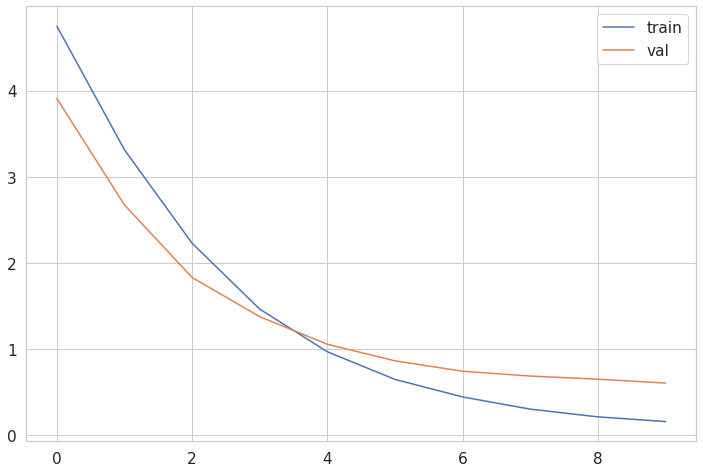

In [25]:
# Plot train/val loss

plot_loss(losses_mob_netv2)

In [26]:
torch.save(mob_netv2.state_dict(), '/content/mob_netv2.pth')

# **Сhecking model inference**

---




In [27]:
# Choose incorrect mob_netv2 predicts for visualization

incorrect_paths, incorrect_images = incorrect_samples(mob_netv2, testloader, DEVICE)

  0%|          | 0/252 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1023: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y = np.asarray(y)


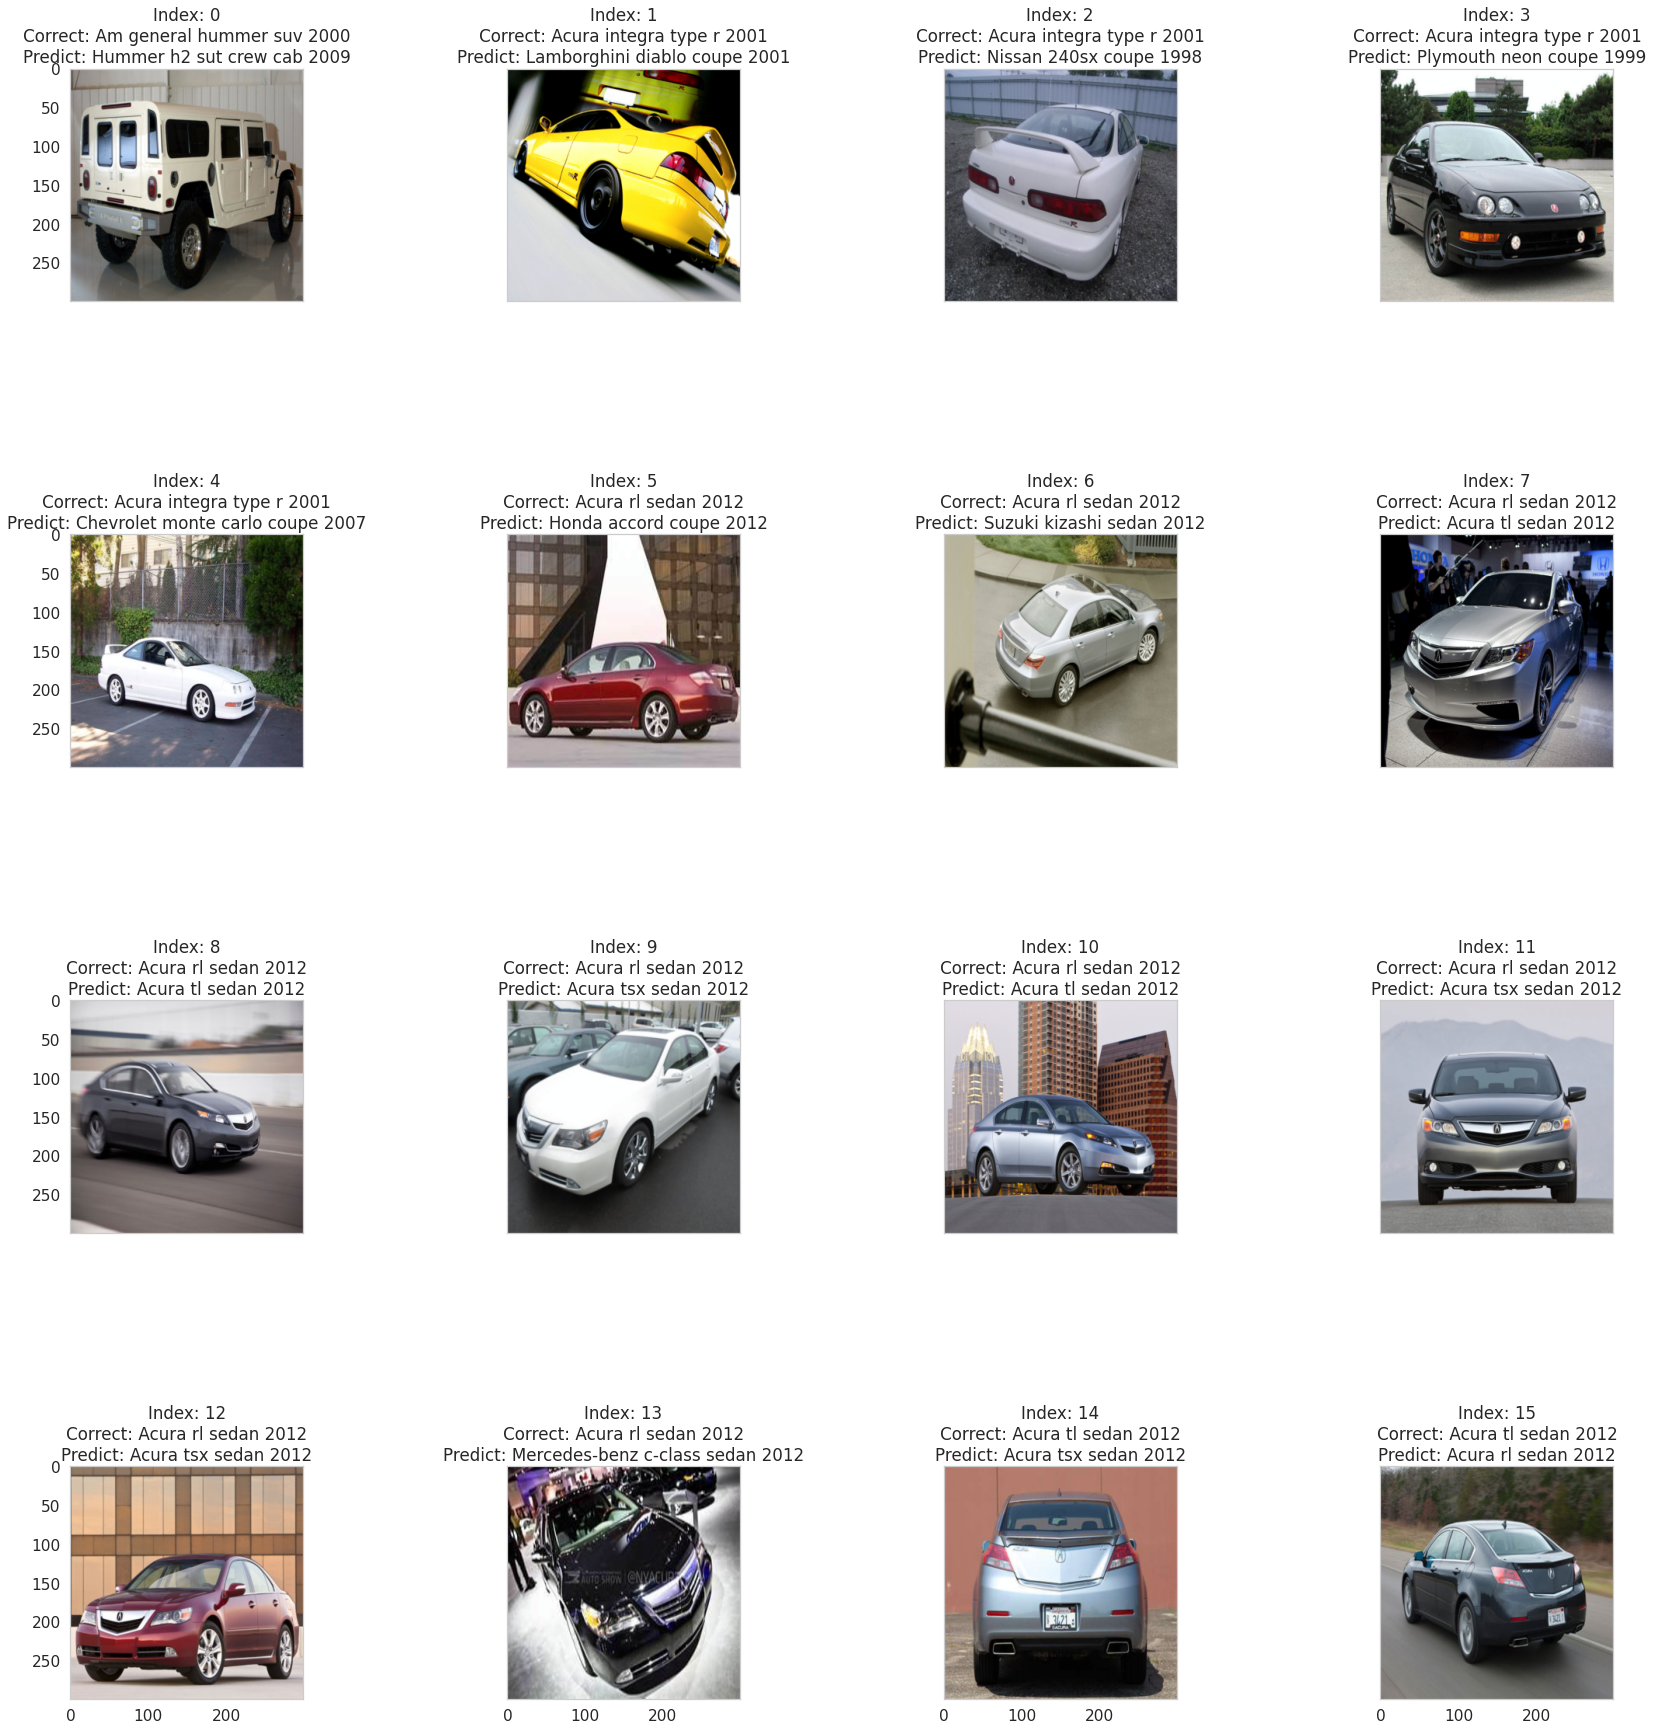

In [34]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(30, 30), \
                        sharey=True, sharex=True)
plt.subplots_adjust(hspace=1)

for i, (fig_x, sample) in enumerate(zip(ax.flatten(), incorrect_images)):
    img, label, pred = sample
    label = " ".join(map(lambda x: x.capitalize(),\
                label_encoder.inverse_transform([label])[0].split('_')))
    pred = " ".join(map(lambda x: x.capitalize(),\
                label_encoder.inverse_transform([pred])[0].split('_')))
    imshow(img.squeeze(0), \
          title=f'Index: {i}\nCorrect: {label}\nPredict: {pred}' ,plt_ax=fig_x)

In [29]:
"""

As we can see, the model most often makes mistakes in classifying the car model. 
Less often, the model makes mistakes in classifying the car brand

"""

# Let`s check accuracy-score for each class

cls_scores_mob_netv2 = class_score(mob_netv2, testloader, train_dataset, DEVICE)
cls_scores_mob_netv2

  0%|          | 0/252 [00:00<?, ?it/s]

,Class,N,Accuracy
59,Chevrolet Express Cargo Van 2007,29,0.17241
69,Chevrolet Silverado 1500 Regular Cab 2012,44,0.38636
23,Audi TTS Coupe 2012,42,0.42857
29,BMW 6 Series Convertible 2007,44,0.52273
68,Chevrolet Silverado 1500 Hybrid Crew Cab 2012,40,0.52500
...,...,...,...
98,FIAT 500 Abarth 2012,27,1.00000
154,Land Rover Range Rover SUV 2012,42,1.00000
148,Jeep Wrangler SUV 2012,43,1.00000
140,Infiniti G Coupe IPL 2012,34,1.00000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


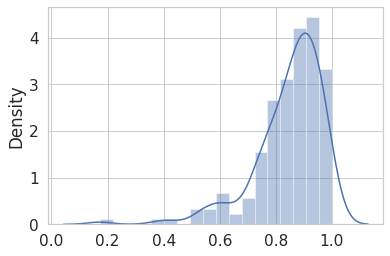

In [30]:
# Plot accuracy distribution 

sns.distplot(x = cls_scores_mob_netv2["Accuracy"])